In [462]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import random

In [250]:
# pip install imblearn
# conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTENC

In [3]:
# Importing the test and train data (20/80 split), and the full dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = pd.read_csv('cleaned_data/diabetes_cleaned.csv')

# Removing the first column
train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
full_data = full_data.iloc[:, 1:]

#### SMOTENC: Used to balance the distribution of responses in readmitted

In [272]:
train.readmitted.value_counts()

0    52232
1     4982
Name: readmitted, dtype: int64

In [429]:
X_train = train.drop(columns="readmitted")
y_train = train.loc[:, "readmitted"]

X_train_types = X_train.dtypes.to_frame().rename(columns={0: "type"})
# get the name of all variables that are objects
object_vars = list(X_train_types.loc[X_train_types.type == "object", :].index)
object_vars = object_vars + ["age", "admission_type_id", "discharge_disposition_id", "admission_source_id", "time_in_hospital", "num_of_changes"]

# get the indices of all 
object_var_indices = []
for i in range(0, len(X_train.columns)):
    if X_train.columns[i] in object_vars:
        object_var_indices.append(i)

In [430]:
object_vars

['race',
 'gender',
 'payer_code',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_of_changes']

In [431]:
smote_nc = SMOTENC(categorical_features=object_var_indices, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [432]:
X_resampled.tail()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,num_of_changes
104459,59711012,720382,Caucasian,Male,75,1,1,7,3,?,...,No,Steady,No,No,No,No,No,Ch,Yes,1
104460,143659228,97051808,Caucasian,Male,75,1,1,7,8,?,...,No,Steady,No,No,No,No,No,No,Yes,0
104461,75845268,34501851,Caucasian,Male,85,1,1,7,7,?,...,No,Steady,No,No,No,No,No,No,Yes,0
104462,117079971,75686609,Caucasian,Female,85,1,1,7,6,MC,...,No,No,No,No,No,No,No,Ch,Yes,0
104463,66346819,23765475,Caucasian,Male,75,5,1,9,4,?,...,No,Steady,No,No,No,No,No,No,Yes,0


In [433]:
X_resampled.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'num_of_changes'],
      dtype='object')

In [434]:
# add the readmitted data back in
X_resampled.loc[:, "readmitted"] = y_resampled
train1 = X_resampled.copy()

In [435]:
train1.readmitted.value_counts()

0    52232
1    52232
Name: readmitted, dtype: int64

#### Summary of KEH LTW Modeling

Variables that have a relationship with `readmitted`, from full dataset EDA:
- `age`: as age increases, the proportion of individuals readmitted to the hospital increases. The number of observations overall increases. This trend persists until age 75, after which the number of hospital visits drop and the proportion of readmitted : not readmitted evens out. This variable is already binned by nature of our original dataset.
    - -> because different age ranges have different distributions of readmitted : not readmitted, look into making each age bin its own predictor, if this isn't happening already
- `time_in_hospital`: as time in hospital increases, the number of observations increase (up until 3 days), and then start to decrease. The ratio of readmitted : not readmitted gradually increases as `time_in_hospital` increases.
    - -> the different distribution of readmittied: not readmitted at for each value of `time_in_hospital`. Similarly, look into making each day bin its own predictor, if it isn't already
- `num_of_changes`: there doesn't seem to be much difference 
- `number_inpatient`: large difference!

Interactions
- as `age` increases, the `time_in_hospital` increases
- as `time_in_hospital` increases, the `um_of_changes` also increases

Models
1. `readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient`
2. `readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age`
3. `readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient`

Thoughts
- More variable selection
    - diag_1, diag_2, diag_3
    - num_medications
    - num_lab_procedures
- Make the bins in `age` and `time_in_hospital` their own predictors
- Evaluate performance of the existing KEH-LTW models with k-fold cross-validation
- Look to see if there are other interactions or transformations

Text(0.5, 0, 'age')

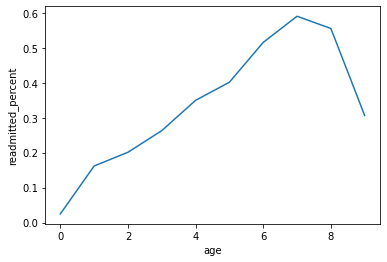

In [436]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
age_data = train1.groupby('age')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = age_data.index, y= age_data['readmitted_percent'])
plt.xlabel('age')

Text(0.5, 0, 'time_in_hospital')

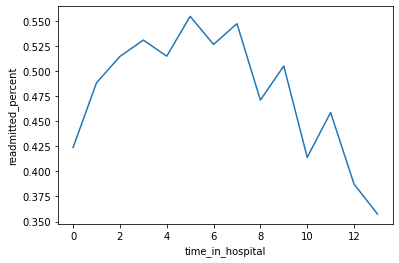

In [437]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
time_data = train1.groupby('time_in_hospital')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = time_data.index, y= time_data['readmitted_percent'])
plt.xlabel('time_in_hospital')

# create these plots for the other binned variables

#### KEH_LTW function for calculating confusion matrix and other evaluation statistics

In [8]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

#### Creating a dataframe containing dummy variables for all binned variables

In [438]:
dummy_preds = ["age", "time_in_hospital", "admission_type_id", "discharge_disposition_id", "admission_source_id"]
train1_dummy = train1.copy()
test_dummy = test.copy()
vars = []

for pred in dummy_preds:
    dummy_train = pd.get_dummies(train1.loc[:, pred])
    dummy_train.columns = [pred + str(x) for x in dummy_train.columns]
    train1_dummy = pd.concat([train1_dummy, dummy_train], axis=1)
    vars.append(list(dummy_train.columns))
    
    dummy_test = pd.get_dummies(test.loc[:, pred])
    dummy_test.columns = [pred + str(x) for x in dummy_test.columns]
    test_dummy = pd.concat([test_dummy, dummy_test], axis=1)
    

train1_dummy.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'num_of_changes',
       'readmitted', 'age5', 'age15', 'age25', 'age35', 'age45', 'age55',
       'age65', 'age75', 'age85', 'age95', 't

In [439]:
train1_dummy.corrwith(train1_dummy.readmitted).sort_values()

admission_type_id3           -0.150623
admission_type_id            -0.125897
num_of_changes               -0.117955
num_procedures               -0.112715
discharge_disposition_id11   -0.090895
encounter_id                 -0.088490
admission_source_id1         -0.087797
age45                        -0.085362
age55                        -0.081969
age35                        -0.078263
age25                        -0.061356
admission_source_id4         -0.060654
time_in_hospital1            -0.059654
age95                        -0.054091
admission_type_id5           -0.048503
age15                        -0.046048
discharge_disposition_id1    -0.045484
discharge_disposition_id7    -0.043879
number_outpatient            -0.043218
age5                         -0.032365
number_emergency             -0.031850
time_in_hospital14           -0.024814
admission_source_id9         -0.024277
time_in_hospital13           -0.021423
time_in_hospital11           -0.020996
time_in_hospital2        

#### Examining multicollinearity

In [440]:
corr_table = train1_dummy.corr()
corr_table.iloc[26:40, 26:40]

,time_in_hospital1,time_in_hospital2,time_in_hospital3,time_in_hospital4,time_in_hospital5,time_in_hospital6,time_in_hospital7,time_in_hospital8,time_in_hospital9,time_in_hospital10,time_in_hospital11,time_in_hospital12,time_in_hospital13,time_in_hospital14
time_in_hospital1,1.000000,-0.178539,-0.186667,-0.158862,-0.129426,-0.115657,-0.097258,-0.082759,-0.063382,-0.057305,-0.047872,-0.043370,-0.037282,-0.034121
time_in_hospital2,-0.178539,1.000000,-0.217015,-0.184688,-0.150468,-0.134459,-0.113069,-0.096213,-0.073686,-0.066621,-0.055655,-0.050421,-0.043343,-0.039668
time_in_hospital3,-0.186667,-0.217015,1.000000,-0.193097,-0.157319,-0.140581,-0.118217,-0.100594,-0.077041,-0.069654,-0.058189,-0.052716,-0.045316,-0.041474
time_in_hospital4,-0.158862,-0.184688,-0.193097,1.000000,-0.133885,-0.119640,-0.100608,-0.085609,-0.065565,-0.059279,-0.049521,-0.044864,-0.038566,-0.035296
time_in_hospital5,-0.129426,-0.150468,-0.157319,-0.133885,1.000000,-0.097472,-0.081966,-0.069747,-0.053417,-0.048295,-0.040346,-0.036551,-0.031420,-0.028756
time_in_hospital6,-0.115657,-0.134459,-0.140581,-0.119640,-0.097472,1.000000,-0.073246,-0.062327,-0.047734,-0.043157,-0.036053,-0.032662,-0.028077,-0.025697
time_in_hospital7,-0.097258,-0.113069,-0.118217,-0.100608,-0.081966,-0.073246,1.000000,-0.052412,-0.040140,-0.036291,-0.030318,-0.027466,-0.023611,-0.021609
time_in_hospital8,-0.082759,-0.096213,-0.100594,-0.085609,-0.069747,-0.062327,-0.052412,1.000000,-0.034156,-0.030881,-0.025798,-0.023372,-0.020091,-0.018388
time_in_hospital9,-0.063382,-0.073686,-0.077041,-0.065565,-0.053417,-0.047734,-0.040140,-0.034156,1.000000,-0.023651,-0.019758,-0.017900,-0.015387,-0.014082
time_in_hospital10,-0.057305,-0.066621,-0.069654,-0.059279,-0.048295,-0.043157,-0.036291,-0.030881,-0.023651,1.000000,-0.017863,-0.016183,-0.013912,-0.012732


In [456]:
diag_values = list(set(list(train1_dummy.diag_1)))
diag_map = {}
diag_unmap = {}

for i in range(len(diag_values)):
    diag_map[diag_values[i]] = i
    diag_unmap[i] = diag_values[i]



In [457]:
train1_dummy.loc[:, "diag_1_num"] = train1_dummy.loc[:, "diag_1"].map(diag_map)
train1_dummy.loc[:, "diag_2_num"] = train1_dummy.loc[:, "diag_2"].map(diag_map)

In [459]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = train1_dummy[['age5', 'age15', 'age25', 'age35', 'age45', 'age55',
       'age65', 'age75', 'age85', 'time_in_hospital1',
       'time_in_hospital2', 'time_in_hospital3', 'time_in_hospital4',
       'time_in_hospital5', 'time_in_hospital6', 'time_in_hospital7',
       'time_in_hospital8', 'time_in_hospital9', 'time_in_hospital10',
       'time_in_hospital11', 'time_in_hospital12', 'time_in_hospital13', 'admission_type_id1', 'admission_type_id3',
       'admission_type_id4', 'discharge_disposition_id7',
       'discharge_disposition_id10', 'discharge_disposition_id11',
       'discharge_disposition_id18', 'discharge_disposition_id27', 'admission_source_id8',
       'admission_source_id9', 'number_inpatient', 'num_of_changes', 'diag_1_num', 'diag_2_num']]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

In [460]:
vif_data

,feature,VIF
0,const,213.011386
1,age5,1.062121
2,age15,1.243681
3,age25,1.540352
4,age35,2.344709
5,age45,4.572591
6,age55,7.478931
7,age65,10.137879
8,age75,11.883549
9,age85,8.532022


#### Inspecting the existing models

Model 1: `readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient`

In [464]:

logit_model = sm.logit(formula = 'readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient', data = train1_dummy).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.672323
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104458
Method:                           MLE   Df Model:                            5
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.03004
Time:                        23:17:50   Log-Likelihood:                -70234.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1006      0.056    -37.394      0.000      -2.211      -1.991
time_in_hospital         0.1815      0.011     15.921      0.000       0.159       0.204
age                      0.0316      0.001     38.812      0.000       0.030       0.033
time_in_hospital:age    -0.0025      0.000    -15.492      0.000      -0.003      -0.002
num_of_changes          -0.5295      0.015    -34.515      0.000      -0.560      -0.499
number_inpatient         0.1471      0.010     14.478      0.000       0.127       0.167
========================================================================================
"""

Text(0.5, 0, 'age')

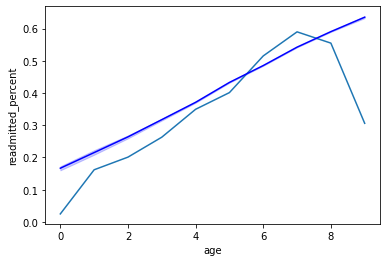

In [469]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
age_data = train1.groupby('age')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
train1_dummy["age_ind"] =  train1_dummy["age"].map({5: 0, 15: 1, 25: 2, 35: 3, 45: 4, 55: 5, 65: 6, 75: 7, 85: 8, 95: 9, 105: 10})
sns.lineplot(x = age_data.index, y= age_data['readmitted_percent'])
sns.lineplot(x = 'age_ind', y= logit_model.predict(train1_dummy), data = train1_dummy, color = 'blue') 
plt.xlabel('age')

Classification accuracy = 58.8%
Precision = 57.7%
TPR or Recall = 65.5%
FNR = 34.5%
FPR = 48.0%
ROC-AUC = 60.8%


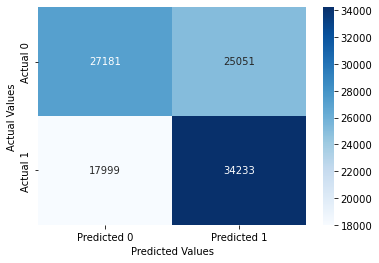

In [466]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, logit_model, cutoff=0.5)

Classification accuracy = 52.2%
Precision = 10.2%
TPR or Recall = 54.2%
FNR = 45.8%
FPR = 48.0%
ROC-AUC = 53.7%


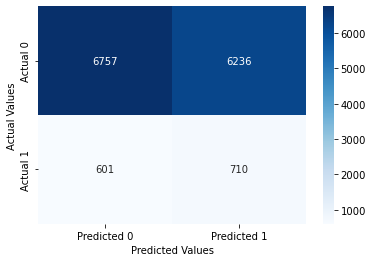

In [467]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, logit_model, cutoff=0.5)

In [465]:
logit_model_all_int = sm.logit(formula = 'readmitted ~ time_in_hospital*age* num_of_changes*number_inpatient', data = train1_dummy).fit() #Developing logistic regression model
logit_model_all_int.summary()

Optimization terminated successfully.
         Current function value: 0.670566
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104448
Method:                           MLE   Df Model:                           15
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.03258
Time:                        23:18:11   Log-Likelihood:                -70050.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -2.3414      0.067    -35.152      0.000      -2.472      -2.211
time_in_hospital                                         0.2446      0.014     17.214      0.000       0.217       0.272
age                                                      0.0335      0.001     34.830      0.000       0.032       0.035
time_in_hospital:age                                    -0.0030      0.000    -15.118      0.000      -0.003      -0.003
num_of_changes                                           0.0342      0.137      0.249      0.804      -0.235       0.303
time_in_hospital:num_of_changes                         -0.1526      0.026     -5.864      0.000      -0.204      -0.102
age:num_of_changes                                      -0.0024      0.002     -1.163      0.245      -0.006       0.002
time_in_hospital:age:num_of_changes                      0.0010      0.000      2.728      0.006       0.000       0.002
number_inpatient                                         0.5451      0.113      4.828      0.000       0.324       0.766
time_in_hospital:number_inpatient                       -0.0606      0.022     -2.819      0.005      -0.103      -0.018
age:number_inpatient                                    -0.0029      0.002     -1.796      0.073      -0.006       0.000
time_in_hospital:age:number_inpatient                    0.0003      0.000      0.859      0.391      -0.000       0.001
num_of_changes:number_inpatient                         -0.1244      0.187     -0.664      0.507      -0.492       0.243
time_in_hospital:num_of_changes:number_inpatient        -0.0003      0.036     -0.009      0.992      -0.071       0.070
age:num_of_changes:number_inpatient                     -0.0005      0.003     -0.178      0.858      -0.006       0.005
time_in_hospital:age:num_of_changes:number_inpatient     0.0004      0.001      0.816      0.415      -0.001       0.001
========================================================================================================================
"""

Model 1.1 -- Making each age group its own predictor

In [474]:
form = 'readmitted ~ ' + ' + '.join(vars[0][:-1])
form

'readmitted ~ age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85'

In [475]:
logit_model_age_dummy = sm.logit(formula = form, data = train1_dummy).fit() 
logit_model_age_dummy.summary()

Optimization terminated successfully.
         Current function value: 0.672258
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104454
Method:                           MLE   Df Model:                            9
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.03014
Time:                        00:03:06   Log-Likelihood:                -70227.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8186      0.049    -16.841      0.000      -0.914      -0.723
age5          -2.8535      0.587     -4.864      0.000      -4.003      -1.704
age15         -0.8262      0.133     -6.217      0.000      -1.087      -0.566
age25         -0.5609      0.090     -6.240      0.000      -0.737      -0.385
age35         -0.2119      0.065     -3.261      0.001      -0.339      -0.085
age45          0.1978      0.054      3.655      0.000       0.092       0.304
age55          0.4189      0.051      8.165      0.000       0.318       0.519
age65          0.8796      0.050     17.494      0.000       0.781       0.978
age75          1.1826      0.050     23.692      0.000       1.085       1.280
age85          1.0395      0.051     20.468      0.000       0.940       1.139
==============================================================================
"""

Classification accuracy = 58.2%
Precision = 55.7%
TPR or Recall = 79.8%
FNR = 20.2%
FPR = 63.4%
ROC-AUC = 60.5%


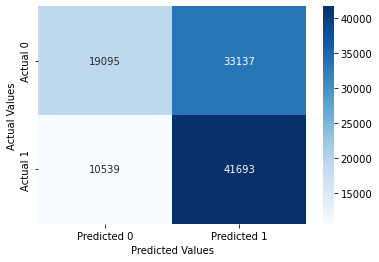

In [476]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, logit_model_age_dummy, cutoff=0.5)

Classification accuracy = 40.0%
Precision = 10.1%
TPR or Recall = 70.0%
FNR = 30.0%
FPR = 63.0%
ROC-AUC = 53.9%


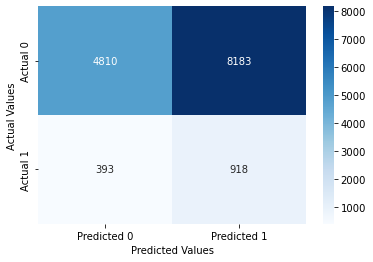

In [477]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, logit_model_age_dummy, cutoff=0.5)

Text(0.5, 0, 'age')

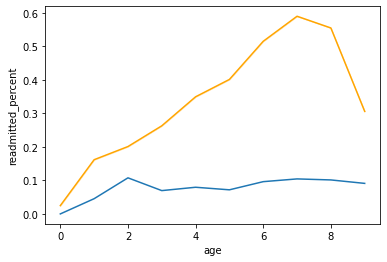

In [480]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
age_data = test.groupby('age')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
test_dummy["age_ind"] =  test_dummy["age"].map({5: 0, 15: 1, 25: 2, 35: 3, 45: 4, 55: 5, 65: 6, 75: 7, 85: 8, 95: 9, 105: 10})
sns.lineplot(x = age_data.index, y= age_data['readmitted_percent'])
sns.lineplot(x = 'age_ind', y= logit_model_age_dummy.predict(test_dummy), data = test_dummy, color = 'orange') 
plt.xlabel('age')

Quick observations
- The classification accuracy for the test data decreased compared to the train data, suggesting overfitting.
- The plot of actual vs. predicted readmitted value for the test data supports that overfitting is happening 
- Precision decreased --> among the classified positives, not many are true positives
- This trend is reflected in the highest false positive rate
- ROC-AUC went down

In [482]:
form = 'readmitted ~ time_in_hospital + ' + ' + '.join(vars[0][:-1]) + ' + num_of_changes + number_inpatient'
form

'readmitted ~ time_in_hospital + age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85 + num_of_changes + number_inpatient'

In [483]:
# try adding the other terms of the model and the age predictors

logit_model_age_dummy_2 = sm.logit(formula = form, data = train1_dummy).fit() 
logit_model_age_dummy_2.summary()

Optimization terminated successfully.
         Current function value: 0.665507
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104451
Method:                           MLE   Df Model:                           12
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.03988
Time:                        00:09:15   Log-Likelihood:                -69521.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7932      0.050    -15.886      0.000      -0.891      -0.695
time_in_hospital     0.0077      0.002      3.396      0.001       0.003       0.012
age5                -2.8084      0.587     -4.785      0.000      -3.959      -1.658
age15               -0.7544      0.134     -5.644      0.000      -1.016      -0.492
age25               -0.4803      0.091     -5.306      0.000      -0.658      -0.303
age35               -0.1463      0.065     -2.237      0.025      -0.275      -0.018
age45                0.2577      0.054      4.735      0.000       0.151       0.364
age55                0.4423      0.052      8.576      0.000       0.341       0.543
age65                0.9100      0.051     18.004      0.000       0.811       1.009
age75                1.1918      0.050     23.761      0.000       1.093       1.290
age85                1.0440      0.051     20.458      0.000       0.944       1.144
num_of_changes      -0.5263      0.015    -34.030      0.000      -0.557      -0.496
number_inpatient     0.1466      0.010     14.338      0.000       0.127       0.167
====================================================================================
"""

Classification accuracy = 59.5%
Precision = 58.0%
TPR or Recall = 69.0%
FNR = 31.0%
FPR = 50.0%
ROC-AUC = 62.8%


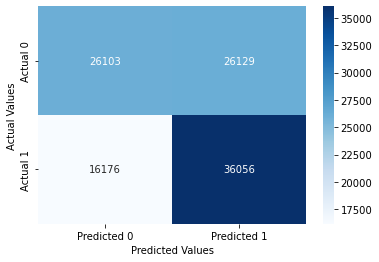

In [484]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, logit_model_age_dummy_2,cutoff=0.5)

Classification accuracy = 51.0%
Precision = 10.1%
TPR or Recall = 55.3%
FNR = 44.7%
FPR = 49.4%
ROC-AUC = 54.9%


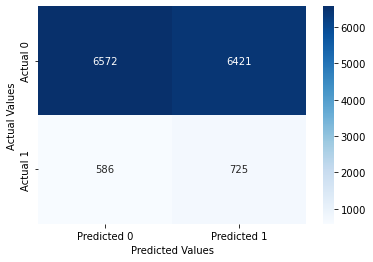

In [485]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, logit_model_age_dummy_2,cutoff=0.5)

Quick observations
- clssification accuracy of test data went up

In [489]:
# Predictors: all age groups, interactions between time_in_hospital and the age groups, num_of_changes, and number_inpatient
form = 'readmitted ~ time_in_hospital*{} + num_of_changes + number_inpatient'.format('time_in_hospital*'.join([(x + " + ") for x in vars[0][:-1]]))
form

'readmitted ~ time_in_hospital*age5 + time_in_hospital*age15 + time_in_hospital*age25 + time_in_hospital*age35 + time_in_hospital*age45 + time_in_hospital*age55 + time_in_hospital*age65 + time_in_hospital*age75 + time_in_hospital*age85 +  + num_of_changes + number_inpatient'

In [490]:
# all predictors (and interaction) of original logit_model

logit_model_age_dummy_3 = sm.logit(formula = form, data = train1_dummy).fit(maxiter = 100) 
logit_model_age_dummy_3.summary()

Optimization terminated successfully.
         Current function value: 0.664681
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104442
Method:                           MLE   Df Model:                           21
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.04107
Time:                        00:12:34   Log-Likelihood:                -69435.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.4670      0.097     -4.829      0.000      -0.656      -0.277
time_in_hospital          -0.0652      0.019     -3.410      0.001      -0.103      -0.028
age5                      -3.5511      1.510     -2.352      0.019      -6.511      -0.591
time_in_hospital:age5      0.2352      0.522      0.450      0.652      -0.788       1.259
age15                     -1.7211      0.239     -7.191      0.000      -2.190      -1.252
time_in_hospital:age15     0.2653      0.053      4.981      0.000       0.161       0.370
age25                     -0.8523      0.165     -5.161      0.000      -1.176      -0.529
time_in_hospital:age25     0.0863      0.037      2.346      0.019       0.014       0.158
age35                     -0.6767      0.123     -5.513      0.000      -0.917      -0.436
time_in_hospital:age35     0.1271      0.025      5.098      0.000       0.078       0.176
age45                     -0.2660      0.105     -2.524      0.012      -0.473      -0.059
time_in_hospital:age45     0.1230      0.021      5.870      0.000       0.082       0.164
age55                     -0.0545      0.101     -0.539      0.590      -0.253       0.144
time_in_hospital:age55     0.1148      0.020      5.728      0.000       0.075       0.154
age65                      0.5796      0.099      5.827      0.000       0.385       0.775
time_in_hospital:age65     0.0740      0.020      3.766      0.000       0.036       0.113
age75                      0.9146      0.099      9.243      0.000       0.721       1.109
time_in_hospital:age75     0.0619      0.020      3.173      0.002       0.024       0.100
age85                      0.8729      0.101      8.666      0.000       0.675       1.070
time_in_hospital:age85     0.0394      0.020      1.991      0.047       0.001       0.078
num_of_changes            -0.5282      0.015    -34.156      0.000      -0.559      -0.498
number_inpatient           0.1456      0.010     14.237      0.000       0.126       0.166
==========================================================================================
"""

Classification accuracy = 59.4%
Precision = 57.9%
TPR or Recall = 69.5%
FNR = 30.5%
FPR = 50.6%
ROC-AUC = 62.7%


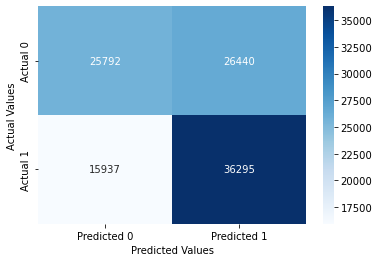

In [491]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, logit_model_age_dummy_3, cutoff=0.5)

Classification accuracy = 50.5%
Precision = 10.1%
TPR or Recall = 55.8%
FNR = 44.2%
FPR = 50.0%
ROC-AUC = 54.4%


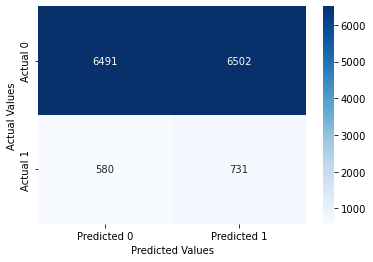

In [492]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, logit_model_age_dummy_3, cutoff=0.5)

#### Model 2: `readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age`

In [493]:
alt_interaction_model = sm.logit('readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age', train1_dummy).fit()
alt_interaction_model.summary()

Optimization terminated successfully.
         Current function value: 0.672452
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104458
Method:                           MLE   Df Model:                            5
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.02986
Time:                        00:13:27   Log-Likelihood:                -70247.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.4783      0.033    -45.347      0.000      -1.542      -1.414
num_of_changes                     -0.1707      0.029     -5.910      0.000      -0.227      -0.114
time_in_hospital                    0.0260      0.003     10.069      0.000       0.021       0.031
num_of_changes:time_in_hospital    -0.0736      0.005    -14.358      0.000      -0.084      -0.064
number_inpatient                    0.1474      0.010     14.496      0.000       0.127       0.167
age                                 0.0214      0.000     47.405      0.000       0.020       0.022
===================================================================================================
"""

Model 2.1 -- Making each `time_in_hospital` group its own predictor

In [494]:
form = 'readmitted ~ ' + ' + '.join(vars[1][:-1]) + ' + num_of_changes + number_inpatient'
form

'readmitted ~ time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + num_of_changes + number_inpatient'

In [495]:
alt_interaction_model_timepred = sm.logit(formula = form, data = train1_dummy).fit() 
alt_interaction_model_timepred.summary()

Optimization terminated successfully.
         Current function value: 0.681039
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104448
Method:                           MLE   Df Model:                           15
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.01747
Time:                        00:13:35   Log-Likelihood:                -71144.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4137      0.075     -5.484      0.000      -0.562      -0.266
time_in_hospital1      0.1612      0.077      2.087      0.037       0.010       0.313
time_in_hospital2      0.4402      0.077      5.733      0.000       0.290       0.591
time_in_hospital3      0.5517      0.077      7.196      0.000       0.401       0.702
time_in_hospital4      0.6356      0.077      8.245      0.000       0.485       0.787
time_in_hospital5      0.5765      0.078      7.405      0.000       0.424       0.729
time_in_hospital6      0.7384      0.078      9.410      0.000       0.585       0.892
time_in_hospital7      0.6414      0.080      8.055      0.000       0.485       0.797
time_in_hospital8      0.7241      0.081      8.921      0.000       0.565       0.883
time_in_hospital9      0.4297      0.085      5.063      0.000       0.263       0.596
time_in_hospital10     0.6012      0.087      6.926      0.000       0.431       0.771
time_in_hospital11     0.2204      0.092      2.404      0.016       0.041       0.400
time_in_hospital12     0.4057      0.094      4.293      0.000       0.220       0.591
time_in_hospital13     0.1331      0.101      1.313      0.189      -0.066       0.332
num_of_changes        -0.5876      0.015    -38.639      0.000      -0.617      -0.558
number_inpatient       0.1483      0.010     14.630      0.000       0.128       0.168
======================================================================================
"""

Classification accuracy = 56.2%
Precision = 54.7%
TPR or Recall = 72.7%
FNR = 27.3%
FPR = 60.2%
ROC-AUC = 58.5%


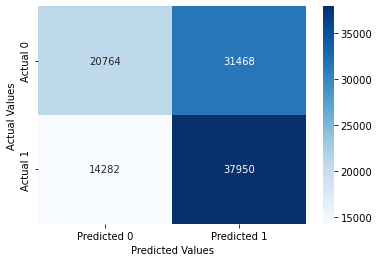

In [496]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, alt_interaction_model_timepred, cutoff=0.5)

Classification accuracy = 42.2%
Precision = 9.5%
TPR or Recall = 61.9%
FNR = 38.1%
FPR = 59.8%
ROC-AUC = 53.0%


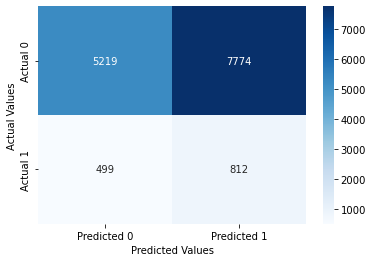

In [497]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, alt_interaction_model_timepred, cutoff=0.5)

Model 2.2: making `time_in_hospital` its own predictor, adding interaction between `time_in_hospital` and `num_of_changes`

In [501]:
form = 'readmitted ~ num_of_changes*{}'.format('num_of_changes*'.join([(x + " + ") for x in vars[1][:-2]]) + 'num_of_changes*time_in_hospital13')
form

'readmitted ~ num_of_changes*time_in_hospital1 + num_of_changes*time_in_hospital2 + num_of_changes*time_in_hospital3 + num_of_changes*time_in_hospital4 + num_of_changes*time_in_hospital5 + num_of_changes*time_in_hospital6 + num_of_changes*time_in_hospital7 + num_of_changes*time_in_hospital8 + num_of_changes*time_in_hospital9 + num_of_changes*time_in_hospital10 + num_of_changes*time_in_hospital11 + num_of_changes*time_in_hospital12 + num_of_changes*time_in_hospital13'

In [502]:
alt_interaction_model_timepred_interact = sm.logit(formula = form, data = train1_dummy).fit() 
alt_interaction_model_timepred_interact.summary()

Optimization terminated successfully.
         Current function value: 0.681168
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104436
Method:                           MLE   Df Model:                           27
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.01728
Time:                        00:14:39   Log-Likelihood:                -71158.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.2914      0.089     -3.278      0.001      -0.466      -0.117
num_of_changes                       -0.8680      0.157     -5.535      0.000      -1.175      -0.561
time_in_hospital1                     0.0189      0.091      0.208      0.835      -0.159       0.197
num_of_changes:time_in_hospital1      0.6119      0.165      3.718      0.000       0.289       0.934
time_in_hospital2                     0.2906      0.090      3.215      0.001       0.113       0.468
num_of_changes:time_in_hospital2      0.6016      0.162      3.723      0.000       0.285       0.918
time_in_hospital3                     0.4590      0.090      5.083      0.000       0.282       0.636
num_of_changes:time_in_hospital3      0.2651      0.161      1.645      0.100      -0.051       0.581
time_in_hospital4                     0.5287      0.091      5.823      0.000       0.351       0.707
num_of_changes:time_in_hospital4      0.3353      0.162      2.074      0.038       0.018       0.652
time_in_hospital5                     0.5242      0.092      5.719      0.000       0.345       0.704
num_of_changes:time_in_hospital5      0.0937      0.164      0.572      0.567      -0.227       0.415
time_in_hospital6                     0.6642      0.092      7.192      0.000       0.483       0.845
num_of_changes:time_in_hospital6      0.2191      0.165      1.331      0.183      -0.103       0.542
time_in_hospital7                     0.6224      0.094      6.640      0.000       0.439       0.806
num_of_changes:time_in_hospital7     -0.0119      0.167     -0.071      0.943      -0.340       0.316
time_in_hospital8                     0.7130      0.095      7.468      0.000       0.526       0.900
num_of_changes:time_in_hospital8     -0.0520      0.171     -0.304      0.761      -0.387       0.283
time_in_hospital9                     0.4055      0.100      4.069      0.000       0.210       0.601
num_of_changes:time_in_hospital9      0.0271      0.179      0.151      0.880      -0.323       0.378
time_in_hospital10                    0.5136      0.103      4.998      0.000       0.312       0.715
num_of_changes:time_in_hospital10     0.2683      0.179      1.501      0.133      -0.082       0.619
time_in_hospital11                    0.1693      0.108      1.568      0.117      -0.042       0.381
num_of_changes:time_in_hospital11     0.1618      0.190      0.851      0.395      -0.211       0.535
time_in_hospital12                    0.3778      0.111      3.389      0.001       0.159       0.596
num_of_changes:time_in_hospital12     0.0781      0.196      0.398      0.691      -0.307       0.463
time_in_hospital13                    0.0912      0.120      0.758      0.449      -0.145       0.327
num_of_changes:time_in_hospital13     0.1562      0.206      0.757      0.449      -0.248       0.561
===============================================================================

Classification accuracy = 56.2%
Precision = 55.9%
TPR or Recall = 58.4%
FNR = 41.6%
FPR = 46.0%
ROC-AUC = 58.2%


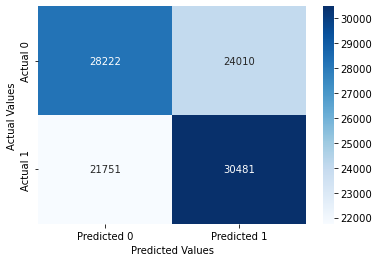

In [503]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, alt_interaction_model_timepred_interact, cutoff=0.5)

Classification accuracy = 53.8%
Precision = 9.8%
TPR or Recall = 49.2%
FNR = 50.8%
FPR = 45.8%
ROC-AUC = 50.7%


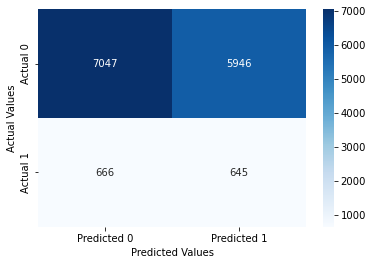

In [504]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, alt_interaction_model_timepred_interact, cutoff=0.5)

Model 2.3: making both `time_in_hospital` and `age` values their own predictors


In [507]:
form = 'readmitted ~ ' + ' + '.join(vars[1][:-1]) + ' + num_of_changes + number_inpatient + ' + ' + '.join(vars[0][:-1])
form

'readmitted ~ time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + num_of_changes + number_inpatient + age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85'

In [508]:
alt_interaction_model_timeagepred = sm.logit(formula = form, data = train1_dummy).fit() 
alt_interaction_model_timeagepred.summary()

Optimization terminated successfully.
         Current function value: 0.662229
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104439
Method:                           MLE   Df Model:                           24
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.04460
Time:                        00:15:41   Log-Likelihood:                -69179.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.3933      0.091    -15.381      0.000      -1.571      -1.216
time_in_hospital1      0.2936      0.078      3.756      0.000       0.140       0.447
time_in_hospital2      0.5875      0.078      7.564      0.000       0.435       0.740
time_in_hospital3      0.6732      0.078      8.681      0.000       0.521       0.825
time_in_hospital4      0.7348      0.078      9.425      0.000       0.582       0.888
time_in_hospital5      0.6521      0.079      8.282      0.000       0.498       0.806
time_in_hospital6      0.8108      0.079     10.217      0.000       0.655       0.966
time_in_hospital7      0.7020      0.081      8.719      0.000       0.544       0.860
time_in_hospital8      0.7855      0.082      9.568      0.000       0.625       0.946
time_in_hospital9      0.4778      0.086      5.564      0.000       0.309       0.646
time_in_hospital10     0.6585      0.088      7.495      0.000       0.486       0.831
time_in_hospital11     0.2730      0.093      2.943      0.003       0.091       0.455
time_in_hospital12     0.4476      0.096      4.680      0.000       0.260       0.635
time_in_hospital13     0.1752      0.103      1.709      0.088      -0.026       0.376
num_of_changes        -0.5326      0.016    -34.322      0.000      -0.563      -0.502
number_inpatient       0.1439      0.010     14.022      0.000       0.124       0.164
age5                  -2.7803      0.587     -4.736      0.000      -3.931      -1.630
age15                 -0.7166      0.134     -5.350      0.000      -0.979      -0.454
age25                 -0.4530      0.091     -4.993      0.000      -0.631      -0.275
age35                 -0.1106      0.066     -1.686      0.092      -0.239       0.018
age45                  0.2904      0.055      5.318      0.000       0.183       0.397
age55                  0.4702      0.052      9.091      0.000       0.369       0.572
age65                  0.9408      0.051     18.557      0.000       0.841       1.040
age75                  1.2186      0.050     24.224      0.000       1.120       1.317
age85                  1.0594      0.051     20.700      0.000       0.959       1.160
======================================================================================
"""

Classification accuracy = 59.7%
Precision = 58.8%
TPR or Recall = 65.3%
FNR = 34.7%
FPR = 45.8%
ROC-AUC = 63.4%


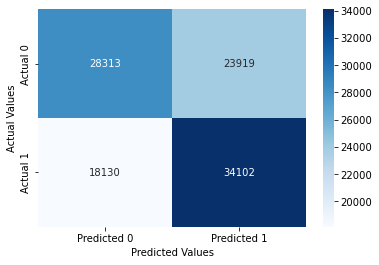

In [509]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, alt_interaction_model_timeagepred, cutoff=0.5)

Classification accuracy = 54.0%
Precision = 10.1%
TPR or Recall = 51.0%
FNR = 49.0%
FPR = 45.6%
ROC-AUC = 54.6%


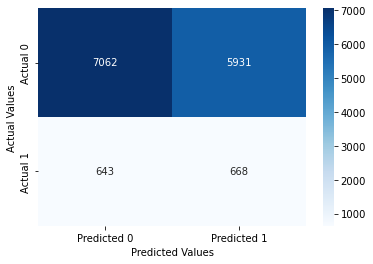

In [510]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, alt_interaction_model_timeagepred, cutoff=0.5)

#### Model 3: `readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient`

In [511]:
both_interaction_model = sm.logit('readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient', train1).fit()

Optimization terminated successfully.
         Current function value: 0.671206
         Iterations 5


In [512]:
both_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104457
Method:                           MLE   Df Model:                            6
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.03165
Time:                        00:16:01   Log-Likelihood:                -70117.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.2196      0.057    -38.949      0.000      -2.331      -2.108
num_of_changes                     -0.1528      0.029     -5.263      0.000      -0.210      -0.096
time_in_hospital                    0.2099      0.012     17.933      0.000       0.187       0.233
num_of_changes:time_in_hospital    -0.0771      0.005    -15.026      0.000      -0.087      -0.067
age                                 0.0322      0.001     39.356      0.000       0.031       0.034
age:time_in_hospital               -0.0027      0.000    -16.136      0.000      -0.003      -0.002
number_inpatient                    0.1464      0.010     14.388      0.000       0.126       0.166
===================================================================================================
"""

### Exploring diagnoses

In [513]:
train1.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'num_of_changes',
       'readmitted'],
      dtype='object')

In [514]:
train1.admission_type_id

0         5
1         1
2         1
3         1
4         1
         ..
104459    1
104460    1
104461    1
104462    1
104463    5
Name: admission_type_id, Length: 104464, dtype: int64

In [114]:
model_diag = sm.logit(formula = 'readmitted ~ diag_1', data = train1).fit() 
model_diag.summary()

Optimization terminated successfully.
         Current function value: 0.690176
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12576
Method:                           MLE   Df Model:                            9
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                0.004287
Time:                        00:58:00   Log-Likelihood:                -8686.5
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 1.730e-12
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1087      0.032      3.408      0.001       0.046       0.171
diag_1[T.diabetes]           -0.0679      0.070     -0.970      0.332      -0.205       0.069
diag_1[T.digestive]          -0.2563      0.068     -3.784      0.000      -0.389      -0.124
diag_1[T.genitourinary]      -0.0144      0.088     -0.163      0.870      -0.187       0.158
diag_1[T.injury]              0.0823      0.073      1.122      0.262      -0.062       0.226
diag_1[T.musculoskeletal]    -0.1490      0.082     -1.811      0.070      -0.310       0.012
diag_1[T.neoplasms]          -0.0957      0.099     -0.970      0.332      -0.289       0.098
diag_1[T.other]              -0.1087      0.054     -2.019      0.043      -0.214      -0.003
diag_1[T.pregnecy]           -1.0095      0.235     -4.301      0.000      -1.470      -0.549
diag_1[T.respiratory]        -0.3840      0.060     -6.433      0.000      -0.501      -0.267
=============================================================================================
"""

Statistically significant predictors: diag_1[T.digestive], diag_1[T.pregnecy], diag_1[T.respiratory]

Classification accuracy = 55.5%
Precision = 53.6%
TPR or Recall = 81.3%
FNR = 18.7%
FPR = 70.3%
ROC-AUC = 58.2%


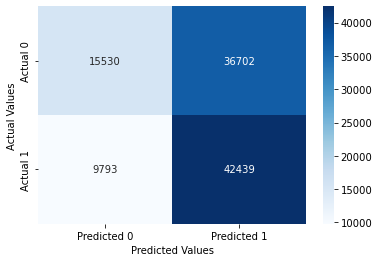

In [515]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, model_diag, cutoff=0.5)

Classification accuracy = 34.3%
Precision = 9.9%
TPR or Recall = 76.6%
FNR = 23.4%
FPR = 70.0%
ROC-AUC = 53.7%


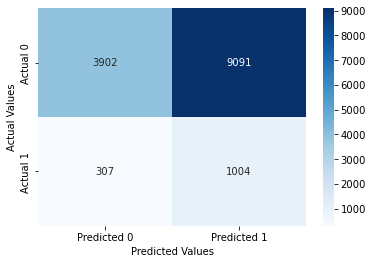

In [516]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, model_diag, cutoff=0.5)

Observations
- Model is better at predicting true positives and not predicting false negatives
- But basically everything is being predicted as negative

In [517]:
model_diag_2 = sm.logit(formula = 'readmitted ~ diag_1 + diag_2', data = train1).fit() 
model_diag_2.summary()

Optimization terminated successfully.
         Current function value: 0.662591
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104445
Method:                           MLE   Df Model:                           18
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.04408
Time:                        00:22:43   Log-Likelihood:                -69217.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.6011      0.012     49.337      0.000       0.577       0.625
diag_1[T.diabetes]           -0.7525      0.027    -28.218      0.000      -0.805      -0.700
diag_1[T.digestive]          -0.7387      0.026    -28.651      0.000      -0.789      -0.688
diag_1[T.genitourinary]      -0.8555      0.034    -25.043      0.000      -0.922      -0.789
diag_1[T.injury]             -0.3690      0.027    -13.579      0.000      -0.422      -0.316
diag_1[T.musculoskeletal]    -0.7667      0.032    -23.993      0.000      -0.829      -0.704
diag_1[T.neoplasms]          -0.8061      0.040    -19.962      0.000      -0.885      -0.727
diag_1[T.other]              -0.3244      0.019    -17.214      0.000      -0.361      -0.287
diag_1[T.pregnecy]           -1.7543      0.164    -10.725      0.000      -2.075      -1.434
diag_1[T.respiratory]        -0.8127      0.022    -37.343      0.000      -0.855      -0.770
diag_2[T.diabetes]           -0.3928      0.021    -18.795      0.000      -0.434      -0.352
diag_2[T.digestive]          -0.8361      0.041    -20.318      0.000      -0.917      -0.755
diag_2[T.genitourinary]      -0.6566      0.028    -23.262      0.000      -0.712      -0.601
diag_2[T.injury]             -0.9889      0.050    -19.665      0.000      -1.087      -0.890
diag_2[T.musculoskeletal]    -1.2736      0.070    -18.311      0.000      -1.410      -1.137
diag_2[T.neoplasms]          -0.6428      0.050    -12.746      0.000      -0.742      -0.544
diag_2[T.other]              -0.0201      0.016     -1.218      0.223      -0.052       0.012
diag_2[T.pregnecy]           -1.3247      0.248     -5.337      0.000      -1.811      -0.838
diag_2[T.respiratory]        -0.6608      0.025    -26.623      0.000      -0.709      -0.612
=============================================================================================
"""

Statistically significant predictors: 
diag_1[T.digestive], diag_1[T.pregnecy], diag_1[T.respiratory]
diag_1[T.neoplasms], diag_2[T.neoplasms]


Classification accuracy = 60.4%
Precision = 61.1%
TPR or Recall = 57.2%
FNR = 42.8%
FPR = 36.4%
ROC-AUC = 63.2%


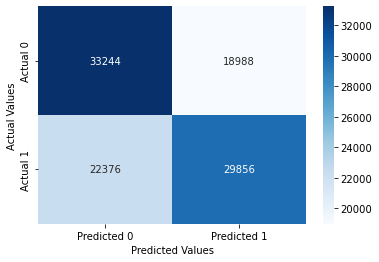

In [518]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, model_diag_2, cutoff=0.5)

Classification accuracy = 61.2%
Precision = 9.8%
TPR or Recall = 39.4%
FNR = 60.6%
FPR = 36.6%
ROC-AUC = 52.2%


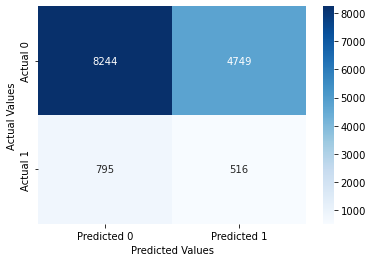

In [519]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, model_diag_2, cutoff=0.5)

In [520]:
model_diag_3 = sm.logit(formula = 'readmitted ~ diag_1 + diag_2 + diag_3', data = train1).fit() 
model_diag_3.summary()

Optimization terminated successfully.
         Current function value: 0.653983
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104436
Method:                           MLE   Df Model:                           27
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.05650
Time:                        00:22:50   Log-Likelihood:                -68318.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.7531      0.015     51.328      0.000       0.724       0.782
diag_1[T.diabetes]           -0.8079      0.027    -29.598      0.000      -0.861      -0.754
diag_1[T.digestive]          -0.7061      0.026    -26.986      0.000      -0.757      -0.655
diag_1[T.genitourinary]      -0.8281      0.035    -23.932      0.000      -0.896      -0.760
diag_1[T.injury]             -0.3504      0.028    -12.702      0.000      -0.405      -0.296
diag_1[T.musculoskeletal]    -0.7206      0.032    -22.289      0.000      -0.784      -0.657
diag_1[T.neoplasms]          -0.7141      0.041    -17.395      0.000      -0.795      -0.634
diag_1[T.other]              -0.3044      0.019    -15.938      0.000      -0.342      -0.267
diag_1[T.pregnecy]           -1.4359      0.184     -7.802      0.000      -1.797      -1.075
diag_1[T.respiratory]        -0.7962      0.022    -36.283      0.000      -0.839      -0.753
diag_2[T.diabetes]           -0.4634      0.021    -21.772      0.000      -0.505      -0.422
diag_2[T.digestive]          -0.8154      0.042    -19.583      0.000      -0.897      -0.734
diag_2[T.genitourinary]      -0.6598      0.029    -23.107      0.000      -0.716      -0.604
diag_2[T.injury]             -0.9381      0.051    -18.378      0.000      -1.038      -0.838
diag_2[T.musculoskeletal]    -1.2023      0.071    -17.042      0.000      -1.341      -1.064
diag_2[T.neoplasms]          -0.5283      0.052    -10.168      0.000      -0.630      -0.426
diag_2[T.other]              -0.0223      0.017     -1.335      0.182      -0.055       0.010
diag_2[T.pregnecy]           -1.2678      0.252     -5.035      0.000      -1.761      -0.774
diag_2[T.respiratory]        -0.6470      0.025    -25.818      0.000      -0.696      -0.598
diag_3[T.diabetes]           -0.3352      0.019    -17.390      0.000      -0.373      -0.297
diag_3[T.digestive]          -0.5433      0.041    -13.391      0.000      -0.623      -0.464
diag_3[T.genitourinary]      -0.5951      0.032    -18.500      0.000      -0.658      -0.532
diag_3[T.injury]             -0.9707      0.059    -16.406      0.000      -1.087      -0.855
diag_3[T.musculoskeletal]    -1.1525      0.069    -16.719      0.000      -1.288      -1.017
diag_3[T.neoplasms]          -0.7250      0.064    -11.279      0.000      -0.851      -0.599
diag_3[T.other]               0.0344      0.016      2.148      0.032       0.003       0.066
diag_3[T.pregnecy]           -1.0356      0.274     -3.782      0.000      -1.572      -0.499
diag_3[T.respiratory]        -0.6582      0.030    -21.846      0.000      -0.717      -0.599
=============================================================================================
"""

Classification accuracy = 61.1%
Precision = 60.6%
TPR or Recall = 63.3%
FNR = 36.7%
FPR = 41.1%
ROC-AUC = 65.4%


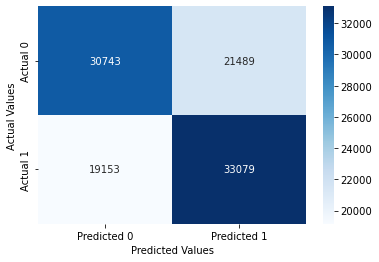

In [521]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, model_diag_3, cutoff=0.5)

Classification accuracy = 56.8%
Precision = 9.2%
TPR or Recall = 41.9%
FNR = 58.1%
FPR = 41.7%
ROC-AUC = 50.6%


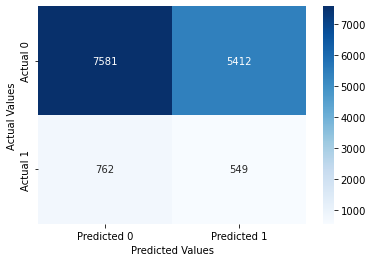

In [522]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, model_diag_3, cutoff=0.5)

#### Exploring admission_type_id, discharge_disposition_id, admission_source_id; each their own predictor after we binned in data cleaning

Model 4.1: making `discharge_disposition_id` its own predictor

In [529]:
form = 'readmitted ~ ' + ' + '.join(['discharge_disposition_id7',
       'discharge_disposition_id10',
       'discharge_disposition_id18'])
form

'readmitted ~ discharge_disposition_id7 + discharge_disposition_id10 + discharge_disposition_id18'

In [530]:
discharge_model = sm.logit(formula = form, data = train1_dummy).fit() 
discharge_model.summary()

Optimization terminated successfully.
         Current function value: 0.691713
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104460
Method:                           MLE   Df Model:                            3
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                0.002069
Time:                        00:24:01   Log-Likelihood:                -72259.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                 1.188e-64
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0065      0.006     -1.021      0.307      -0.019       0.006
discharge_disposition_id7     -2.0696      0.175    -11.859      0.000      -2.412      -1.728
discharge_disposition_id10    -0.5615      0.304     -1.849      0.064      -1.157       0.034
discharge_disposition_id18     0.2326      0.028      8.169      0.000       0.177       0.288
==============================================================================================
"""

Classification accuracy = 50.6%
Precision = 55.6%
TPR or Recall = 5.6%
FNR = 94.4%
FPR = 4.5%
ROC-AUC = 50.8%


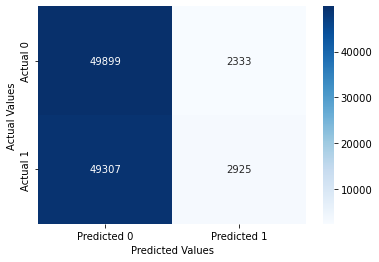

In [531]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, discharge_model, cutoff=0.5)

Classification accuracy = 86.9%
Precision = 7.7%
TPR or Recall = 4.0%
FNR = 96.0%
FPR = 4.8%
ROC-AUC = 49.7%


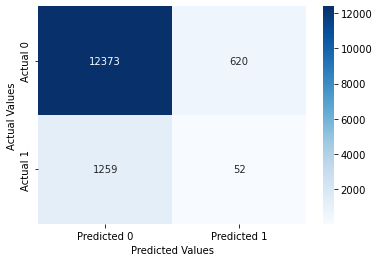

In [532]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, discharge_model, cutoff=0.5)

Model 4.1: making `admission_source_id` its own predictor

In [537]:
form = 'readmitted ~ ' + ' + '.join(['admission_source_id8',
       'admission_source_id9'])
form

'readmitted ~ admission_source_id8 + admission_source_id9'

In [538]:
admission_model = sm.logit(formula = form, data = train1_dummy).fit() 
admission_model.summary()

Optimization terminated successfully.
         Current function value: 0.692811
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104461
Method:                           MLE   Df Model:                            2
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:               0.0004855
Time:                        00:25:36   Log-Likelihood:                -72374.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                 5.395e-16
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0131      0.006      2.053      0.040       0.001       0.026
admission_source_id8    -2.3157      1.049     -2.208      0.027      -4.371      -0.260
admission_source_id9    -0.1955      0.025     -7.844      0.000      -0.244      -0.147
========================================================================================
"""

Classification accuracy = 50.6%
Precision = 50.3%
TPR or Recall = 94.0%
FNR = 6.0%
FPR = 92.7%
ROC-AUC = 50.6%


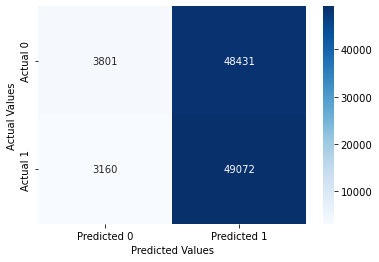

In [539]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, admission_model, cutoff=0.5)

Classification accuracy = 15.3%
Precision = 9.2%
TPR or Recall = 93.5%
FNR = 6.5%
FPR = 92.6%
ROC-AUC = 50.4%


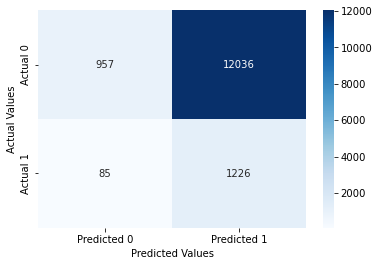

In [540]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, admission_model, cutoff=0.5)

Model 4.3: making `admission_type` its own predictor

In [541]:
form = 'readmitted ~ ' + ' + '.join(['admission_type_id1', 'admission_type_id3',
       'admission_type_id4'])
form

'readmitted ~ admission_type_id1 + admission_type_id3 + admission_type_id4'

In [542]:
admission_type_model = sm.logit(formula = form, data = train1_dummy).fit() 
admission_type_model.summary()

Optimization terminated successfully.
         Current function value: 0.679143
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104460
Method:                           MLE   Df Model:                            3
Date:                Sat, 25 Feb 2023   Pseudo R-squ.:                 0.02020
Time:                        00:26:07   Log-Likelihood:                -70946.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2973      0.020    -14.838      0.000      -0.337      -0.258
admission_type_id1     0.4742      0.021     22.297      0.000       0.432       0.516
admission_type_id3    -0.4791      0.027    -17.939      0.000      -0.531      -0.427
admission_type_id4    -1.3121      1.096     -1.198      0.231      -3.460       0.835
======================================================================================
"""

Classification accuracy = 56.7%
Precision = 54.4%
TPR or Recall = 82.7%
FNR = 17.3%
FPR = 69.3%
ROC-AUC = 57.0%


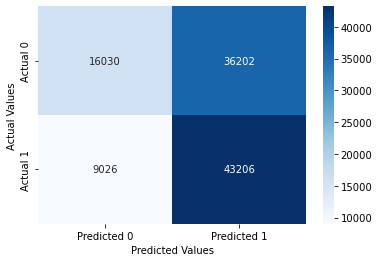

In [543]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, admission_type_model, cutoff=0.5)

Classification accuracy = 34.8%
Precision = 9.3%
TPR or Recall = 69.6%
FNR = 30.4%
FPR = 68.7%
ROC-AUC = 50.4%


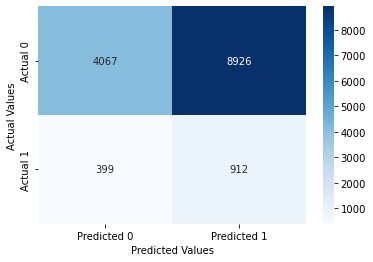

In [544]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, admission_type_model, cutoff=0.5)

### Combine promising predictors from all above models


diag_1[T.digestive], diag_1[T.pregnecy], diag_1[T.respiratory]
diag_1[T.neoplasms], diag_2[T.neoplasms]

all the values of age



In [545]:
signif_diag = ["diag_1[T.digestive]", "diag_1[T.pregnecy]", "diag_1[T.respiratory]", "diag_1[T.neoplasms]", "diag_2[T.neoplasms]", "discharge_disposition_id7", "discharge_disposition_id7", "admission_type_id1", "admission_type_id3"]

In [547]:
form = 'readmitted ~ ' + ' + '.join(vars[0][:-1]) + ' + '.join(signif_diag)
form

'readmitted ~ age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85diag_1[T.digestive] + diag_1[T.pregnecy] + diag_1[T.respiratory] + diag_1[T.neoplasms] + diag_2[T.neoplasms] + discharge_disposition_id7 + discharge_disposition_id7 + admission_type_id1 + admission_type_id3'

In [548]:
single_model = sm.logit(formula = form, data = train1_dummy).fit() 
single_model.summary()

PatsyError: Error evaluating factor: NameError: name 'T' is not defined
    readmitted ~ age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85diag_1[T.digestive] + diag_1[T.pregnecy] + diag_1[T.respiratory] + diag_1[T.neoplasms] + diag_2[T.neoplasms] + discharge_disposition_id7 + discharge_disposition_id7 + admission_type_id1 + admission_type_id3
                                                                                                                                                        ^^^^^^^^^^^^^^^^^^^

Classification accuracy = 50.7%
Precision = 50.4%
TPR or Recall = 81.8%
FNR = 18.2%
FPR = 80.5%
ROC-AUC = 50.8%


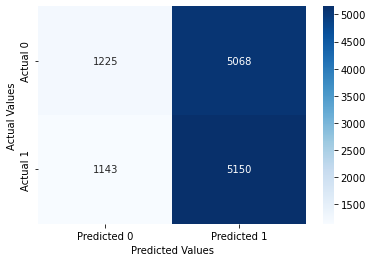

In [ ]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, admission_type_model, cutoff=0.5)

Classification accuracy = 25.5%
Precision = 9.2%
TPR or Recall = 80.5%
FNR = 19.5%
FPR = 80.0%
ROC-AUC = 50.0%


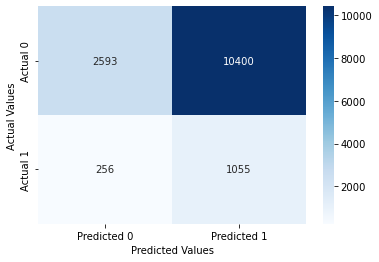

In [ ]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, admission_type_model, cutoff=0.5)